# Zillow Time Series Modelling - ARIMA Tuning

![houses](images/houses.png)

## Author: [Patricio Contreras](https://www.linkedin.com/in/pcontreras97/)

## Overview

After obtaining the results we did in the previous [notebook](ARIMA.ipynb), it is clear that model tuning is required in order to produce accurate forecasts.  In this notebook, we'll take a look at how using a different evaluation criterion affects each model's performance.

In [1]:
# import necessary Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# importing the top 5 time series csv
df_top5 = pd.read_csv("data/df_top5.csv", index_col = 0)
df_top5.index = pd.to_datetime(df_top5.index)

df_top5.head()

,11216,33936,94804,11222,94301
2010-01-01,490200.0,46400.0,169900.0,608500.0,1710700.0
2010-02-01,490600.0,46300.0,170400.0,610000.0,1718100.0
2010-03-01,489000.0,46300.0,170100.0,599200.0,1715300.0
2010-04-01,483400.0,45500.0,167800.0,581600.0,1716500.0
2010-05-01,478500.0,44800.0,167000.0,577400.0,1723000.0


In [3]:
# print out dimensions to make sure we're dealing with same data as before
print("Number of rows:", df_top5.shape[0])
print("Number of columns:", df_top5.shape[1])

Number of rows: 100
Number of columns: 5


## ARIMA Model Tuning

### Finding ARIMA Parameters Through Mean Squared Error

An important takeaway from the ARIMA [notebook](ARIMA.ipynb) is that the model with the lowest AIC won't always have the best testing mean squared error (MSE).  This phenomenon isn't unusual given the nature of AIC.  While AIC tends to favour models with fewer features (whilst trying to achieve the best goodness of fit), minimising MSE also takes into account testing data and can be really valuable when forecasting.

In this notebook, we'll still perform an exhaustive grid search for `p`, `d`, and `q`, however, rather than selecting the model with the lowest AIC, this time we'll choose the model that returns the lowest MSE:

In [4]:
import itertools
p = d = q = range(6)
# every possible combination of p, d, and q
pdq = list(itertools.product(p,d,q))
# display preview
pdq[:5]

[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3), (0, 0, 4)]

In [5]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# splitting the data (85-15)
train = df_top5.iloc[:80,:]
test = df_top5.iloc[80:,:]

zip_MSEs = {}
# for each zip code
for col in range(train.shape[1]):
    df = train.iloc[:,col]
    MSE = []
    zipcode = train.columns[col]
    # for each possible p, d, q combination
    for params in pdq:
        try:
            model = ARIMA(df, order = params)
            output = model.fit()
            forecast = output.predict("2016-09-01", end = "2018-04-01", 
                                      dynamic = False)
            mse = ((forecast - test.iloc[:,col])**2).mean()
            # store model's test MSE
            MSE.append([params, mse])
        except:
            continue
    # store zip code's AIC list
    zip_MSEs[zipcode] = MSE

In [6]:
# printing out "optimal" parameter values and associated MSE
for key in zip_MSEs:
    print(key)
    result = sorted(zip_MSEs[key], key = lambda x: x[1])[0]
    print("Best parameters:", result[0])
    print("MSE:", result[1])
    print("----------------------")

11216
Best parameters: (3, 3, 3)
MSE: 729844546.4935256
----------------------
33936
Best parameters: (3, 2, 4)
MSE: 498795.4898813517
----------------------
94804
Best parameters: (4, 1, 4)
MSE: 56149089.9312195
----------------------
11222
Best parameters: (5, 1, 5)
MSE: 972665924.876826
----------------------
94301
Best parameters: (1, 4, 4)
MSE: 2030678071.651291
----------------------


### Building the ARIMA Models and Checking Residual Diagnostics

Now that we have our parameter values for each zip code, let's fit ARIMA Models again and see how results compare to before.  Again, we'll call `summary()` to inspect the coefficients and plot residual diagnostics using `plot_diagnostics()` to ensure there are no patterns:

In [7]:
# instantiate ARIMA object with MSE optimal parameter values
ARIMA_11216 = ARIMA(train["11216"], order = (3,3,3))
ARIMA_33936 = ARIMA(train["33936"], order = (3,2,4))
ARIMA_94804 = ARIMA(train["94804"], order = (4,1,4))
ARIMA_11222 = ARIMA(train["11222"], order = (5,1,5))
ARIMA_94301 = ARIMA(train["94301"], order = (1,4,4))

# Fit the model and print results
output_11216 = ARIMA_11216.fit()
output_33936 = ARIMA_33936.fit()
output_94804 = ARIMA_94804.fit()
output_11222 = ARIMA_11222.fit()
output_94301 = ARIMA_94301.fit()

print(output_11216.summary())

                               SARIMAX Results                                
Dep. Variable:                  11216   No. Observations:                   80
Model:                 ARIMA(3, 3, 3)   Log Likelihood                -788.633
Date:                Wed, 17 Mar 2021   AIC                           1591.265
Time:                        19:30:32   BIC                           1607.672
Sample:                    01-01-2010   HQIC                          1597.828
                         - 08-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0899      4.049     -0.269      0.788      -9.026       6.847
ar.L2          0.0376      1.500      0.025      0.980      -2.902       2.977
ar.L3          0.3691      1.459      0.253      0.8

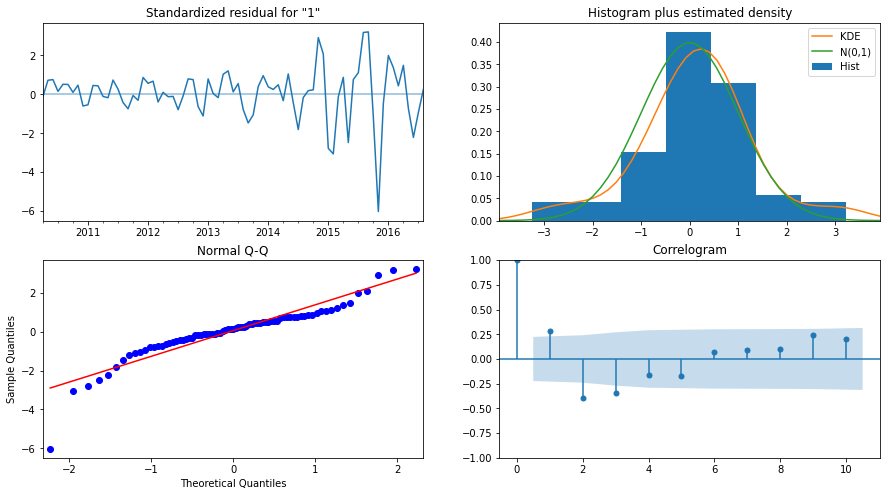

In [8]:
# residual diagnostics
output_11216.plot_diagnostics(figsize = (15,8))

plt.show()

### Summary and Residual Diagnostics for Zip Code 33936

In [9]:
print(output_33936.summary())

                               SARIMAX Results                                
Dep. Variable:                  33936   No. Observations:                   80
Model:                 ARIMA(3, 2, 4)   Log Likelihood                -550.031
Date:                Wed, 17 Mar 2021   AIC                           1116.062
Time:                        19:30:33   BIC                           1134.916
Sample:                    01-01-2010   HQIC                          1123.610
                         - 08-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4356      0.094      4.648      0.000       0.252       0.619
ar.L2         -0.4459      0.103     -4.346      0.000      -0.647      -0.245
ar.L3          0.7257      0.105      6.901      0.0

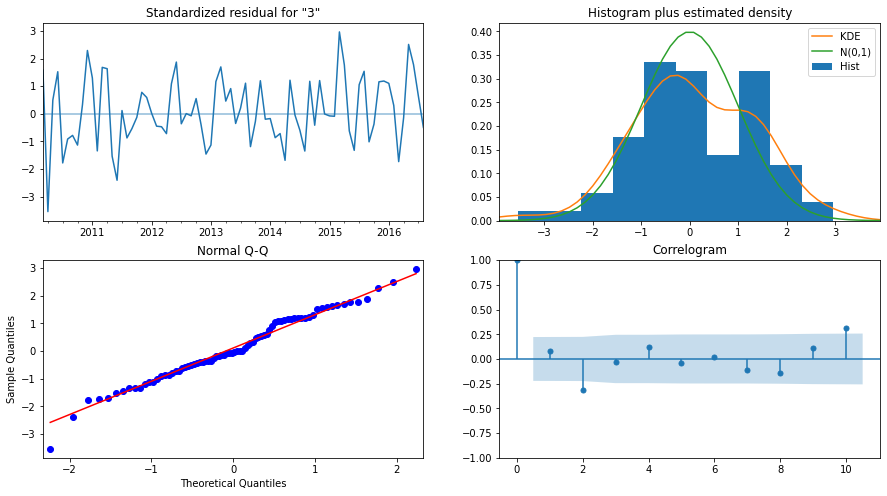

In [10]:
# residual diagnostics
output_33936.plot_diagnostics(figsize = (15,8))

plt.show()

### Summary and Residual Diagnostics for Zip Code 94804

In [11]:
print(output_94804.summary())

                               SARIMAX Results                                
Dep. Variable:                  94804   No. Observations:                   80
Model:                 ARIMA(4, 1, 4)   Log Likelihood               -1113.056
Date:                Wed, 17 Mar 2021   AIC                           2244.112
Time:                        19:30:33   BIC                           2265.437
Sample:                    01-01-2010   HQIC                          2252.656
                         - 08-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8745      0.028    -30.940      0.000      -0.930      -0.819
ar.L2          0.0323      0.015      2.163      0.031       0.003       0.062
ar.L3          0.9319      0.015     62.898      0.0

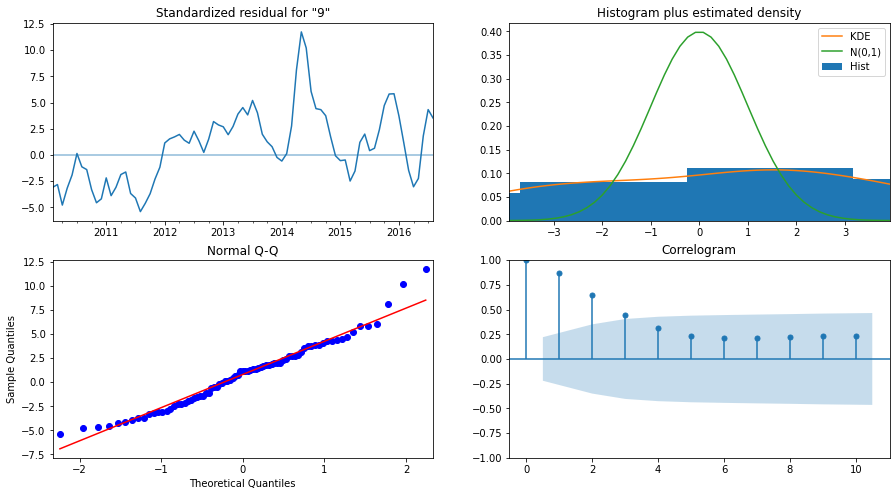

In [12]:
# residual diagnostics
output_94804.plot_diagnostics(figsize = (15,8))

plt.show()

### Summary and Residual Diagnostics for Zip Code 11222

In [13]:
print(output_11222.summary())

                               SARIMAX Results                                
Dep. Variable:                  11222   No. Observations:                   80
Model:                 ARIMA(5, 1, 5)   Log Likelihood                -982.761
Date:                Wed, 17 Mar 2021   AIC                           1987.521
Time:                        19:30:34   BIC                           2013.585
Sample:                    01-01-2010   HQIC                          1997.963
                         - 08-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5319      0.015     34.967      0.000       0.502       0.562
ar.L2          1.2538      0.022     57.220      0.000       1.211       1.297
ar.L3         -1.2617      0.011   -112.802      0.0

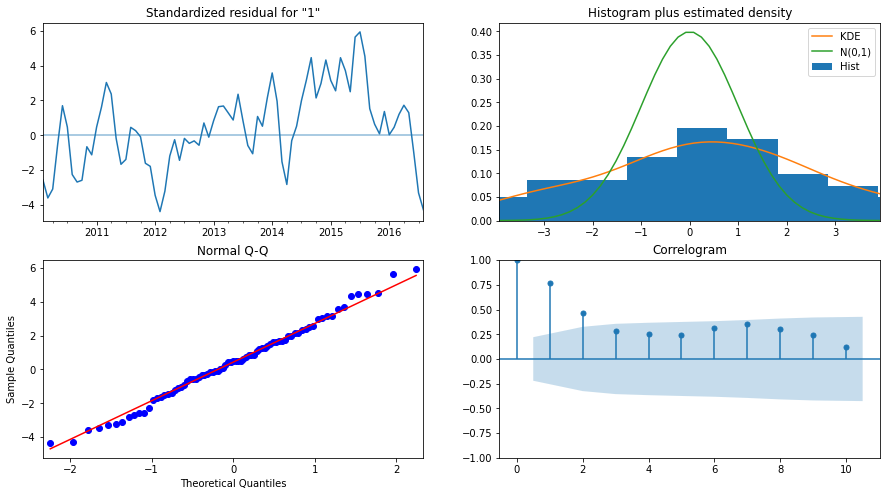

In [14]:
# residual diagnostics
output_11222.plot_diagnostics(figsize = (15,8))

plt.show()

### Summary and Residual Diagnostics for Zip Code 94301

In [15]:
print(output_94301.summary())

                               SARIMAX Results                                
Dep. Variable:                  94301   No. Observations:                   80
Model:                 ARIMA(1, 4, 4)   Log Likelihood                -826.702
Date:                Wed, 17 Mar 2021   AIC                           1665.403
Time:                        19:30:34   BIC                           1679.388
Sample:                    01-01-2010   HQIC                          1670.992
                         - 08-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8196      0.100      8.224      0.000       0.624       1.015
ma.L1         -1.8925      0.211     -8.973      0.000      -2.306      -1.479
ma.L2          0.8319      0.259      3.216      0.0

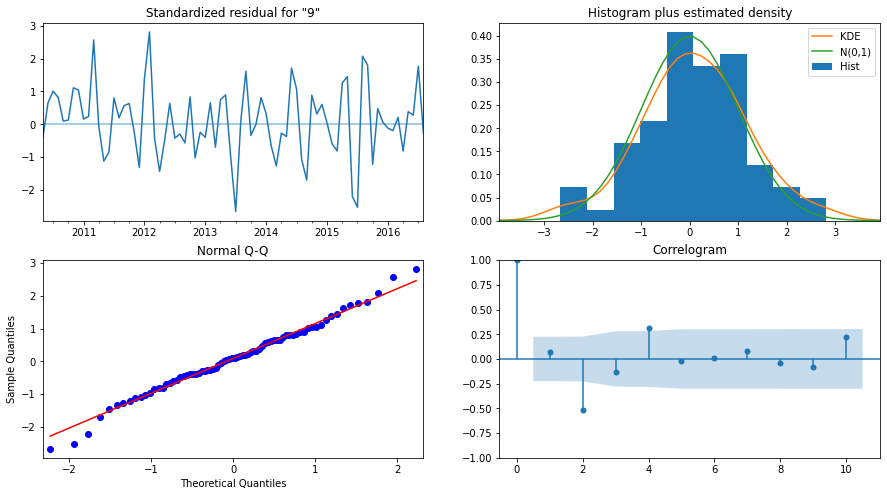

In [16]:
# residual diagnostics
output_94301.plot_diagnostics(figsize = (15,8))

plt.show()

## Comments

The ARIMA model summaries and residual diagnostics are summarized below:

- Residual diagnostics for zip codes 11216, 33936, and 94301 are pretty good.  The residuals are fairly centred around 0, have constant variance, and their distribution resembles a standard normal.  Unfortunately the same cannot be said for zip codes 94804 and 11222.

- Even though AIC scores have increased quite a lot for the lowest AIC-scoring models before, they haven't increased that much for the rest

- Number of coefficients with p-value greater than our threshold has increased!

## Testing Model Performance Through Forecasting and MSE

It's now time to use our testing data and see how well our model predicts it.  As we did before, training, test, and forecasted values will be plotted along with the test MSE.  Furthermore, a percent difference in MSE between the new results and old will also be printed:

### Test Mean Squared Errors

The Mean Squared Error of our forecasts is 729844546.49
The percent difference in MSE from prev notebook: 98.05 %


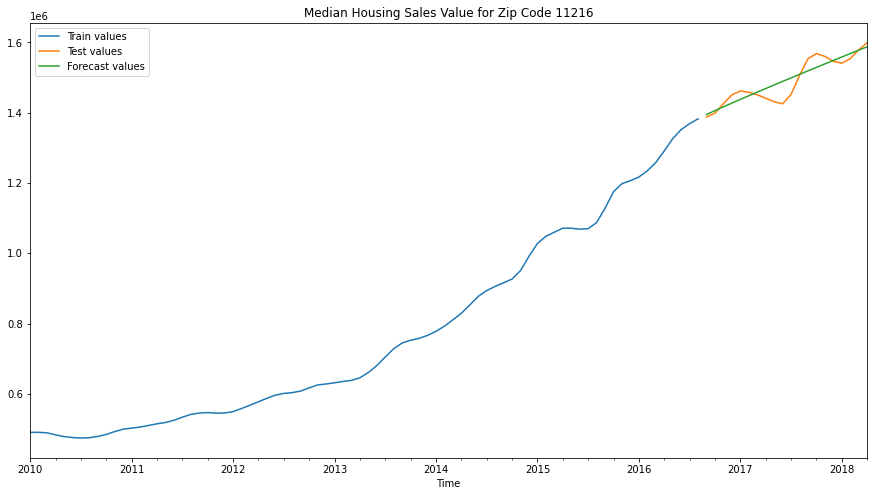

In [17]:
forecast = output_11216.predict("2016-09-01", end = "2018-04-01", dynamic = False)

ax = train["11216"].plot(title = "Median Housing Sales Value for Zip Code 11216",
                         xlabel = "Time", label = "Train values", figsize = (15,8))
test["11216"].plot(label = "Test values", ax = ax)
forecast.plot(label = "Forecast values", ax = ax)
plt.legend();

# Compute the mean square error
mse = ((forecast - test["11216"])**2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
pct_diff = ((37412565181.16-mse)/37412565181.16)*100
print("The percent difference in MSE from prev notebook:", round(pct_diff, 2), "%")

The Mean Squared Error of our forecasts is 498795.49
The percent difference in MSE from prev notebook: 99.4 %


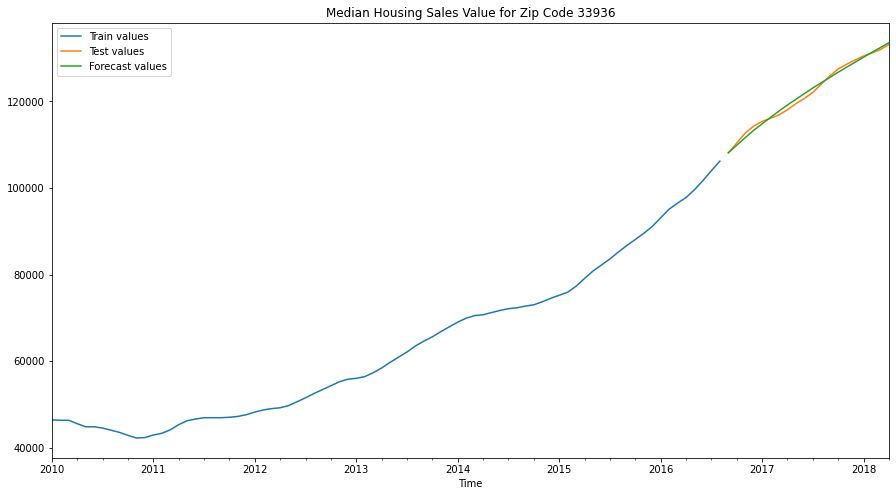

In [18]:
forecast = output_33936.predict("2016-09-01", end = "2018-04-01", dynamic = False)

ax = train["33936"].plot(title = "Median Housing Sales Value for Zip Code 33936",
                         xlabel = "Time", label = "Train values", figsize = (15,8))
test["33936"].plot(label = "Test values", ax = ax)
forecast.plot(label = "Forecast values", ax = ax)
plt.legend();

# Compute the mean square error
mse = ((forecast - test["33936"])**2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
pct_diff = ((83076000.0-mse)/83076000.0)*100
print("The percent difference in MSE from prev notebook:", round(pct_diff, 2), "%")

The Mean Squared Error of our forecasts is 56149089.93
The percent difference in MSE from prev notebook: 99.86 %


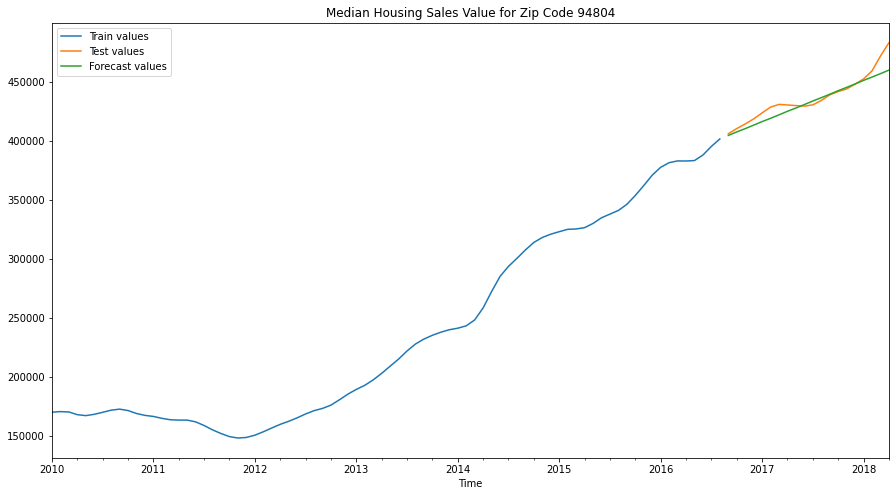

In [19]:
forecast = output_94804.predict("2016-09-01", end = "2018-04-01", dynamic = False)

ax = train["94804"].plot(title = "Median Housing Sales Value for Zip Code 94804",
                         xlabel = "Time", label = "Train values", figsize = (15,8))
test["94804"].plot(label = "Test values", ax = ax)
forecast.plot(label = "Forecast values", ax = ax)
plt.legend();

# Compute the mean square error
mse = ((forecast - test["94804"])**2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
pct_diff = ((39373057967.62-mse)/39373057967.62)*100
print("The percent difference in MSE from prev notebook:", round(pct_diff, 2), "%")

The Mean Squared Error of our forecasts is 972665924.88
The percent difference in MSE from prev notebook: 99.93 %


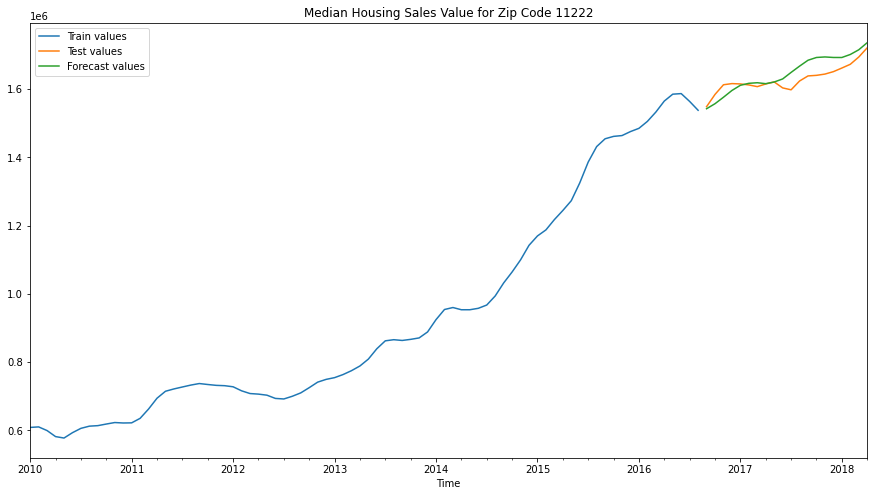

In [20]:
forecast = output_11222.predict("2016-09-01", end = "2018-04-01", dynamic = False)

ax = train["11222"].plot(title = "Median Housing Sales Value for Zip Code 11222",
                         xlabel = "Time", label = "Train values", figsize = (15,8))
test["11222"].plot(label = "Test values", ax = ax)
forecast.plot(label = "Forecast values", ax = ax)
plt.legend();

# Compute the mean square error
mse = ((forecast - test["11222"])**2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
pct_diff = ((1448649230194.62-mse)/1448649230194.62)*100
print("The percent difference in MSE from prev notebook:", round(pct_diff, 2), "%")

The Mean Squared Error of our forecasts is 2030678071.65
The percent difference in MSE from prev notebook: 99.98 %


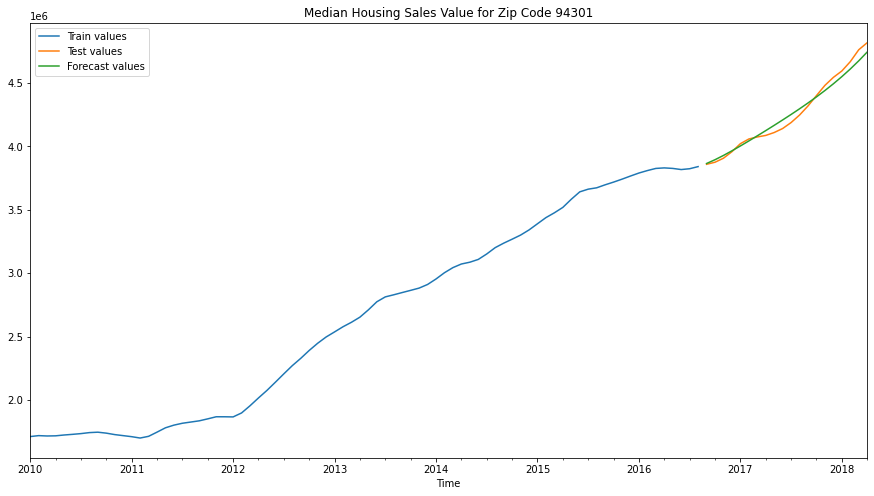

In [21]:
forecast = output_94301.predict("2016-09-01", end = "2018-04-01", dynamic = False)

ax = train["94301"].plot(title = "Median Housing Sales Value for Zip Code 94301",
                         xlabel = "Time", label = "Train values", figsize = (15,8))
test["94301"].plot(label = "Test values", ax = ax)
forecast.plot(label = "Forecast values", ax = ax)
plt.legend();

# Compute the mean square error
mse = ((forecast - test["94301"])**2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
pct_diff = ((12423558370338.89-mse)/12423558370338.89)*100
print("The percent difference in MSE from prev notebook:", round(pct_diff, 2), "%")

## Thoughts on MSE Results

Using MSE as the criterion to select `p`, `d`, and `q` proved to be fruitful as the forecasts more accurately predict the testing data.  This can be seen as the percent difference in MSE between our old models and these new models is quite substantial.

---

## Producing and Visualising Forecasts

Now that we've evaluated the models using the testing data, let's make predictions for values outside the scope of our data (past 2018-04-01).  This can be a good way to see which zip code will probably have the highest median housing sales value in the end.

We'll forecast values 10 years into the future:

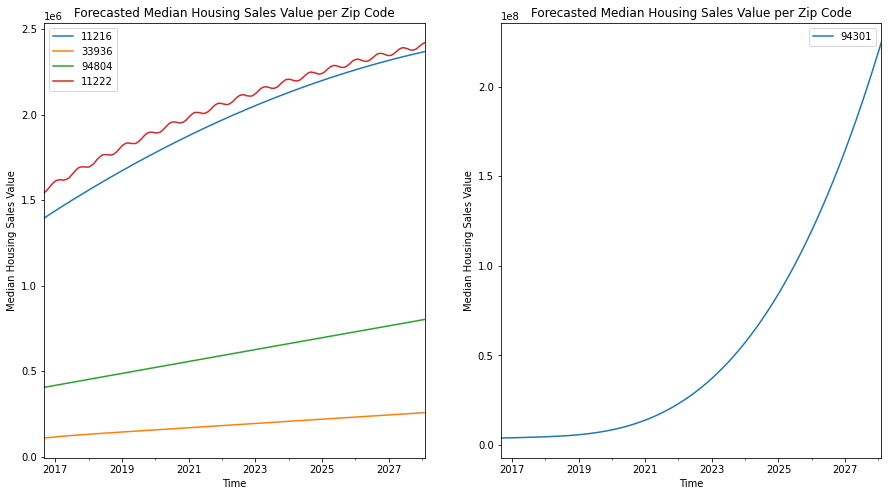

In [22]:
# Get forecast 500 steps ahead in future
prediction_11216 = output_11216.get_forecast(steps = 138)
prediction_33936 = output_33936.get_forecast(steps = 138)
prediction_94804 = output_94804.get_forecast(steps = 138)
prediction_11222 = output_11222.get_forecast(steps = 138)
prediction_94301 = output_94301.get_forecast(steps = 138)

fig, axes = plt.subplots(1, 2, figsize = (15,8))

prediction_11216.predicted_mean.plot(title = "Forecasted Median Housing Sales Value per Zip Code",
                                          xlabel = "Time", ylabel = "Median Housing Sales Value",
                                          label = "11216", ax = axes[0])
prediction_33936.predicted_mean.plot(label = "33936", ax = axes[0])
prediction_94804.predicted_mean.plot(label = "94804", ax = axes[0])
prediction_11222.predicted_mean.plot(label = "11222", ax = axes[0])
axes[0].legend()

prediction_94301.predicted_mean.plot(title = "Forecasted Median Housing Sales Value per Zip Code",
                                          xlabel = "Time", ylabel = "Median Housing Sales Value",
                                          label = "94301", ax = axes[1])
axes[1].legend();
plt.savefig("./images/forecasts.png", dpi = 150, bbox_inches = "tight")

I decided to plot two graphs instead of one since zip code 94301 is on a completely different scale than all other zip codes.

It is clear that all zip codes will still increase in value over time, however, the rate for zip codes 11222 and 11216 seems to go down over the years.  In contrast, the value for zip code 94301 is predicted to skyrocket in the mid 2020s.  Keep in mind, as we predict further and further into the future, our confidence intervals will also widen.  This is because we're less confident in our predictions as opposed to in the near future.

## Limitations and Recommendations

Even though the ARIMA models produced relatively good predictions when compared to the test data and gave some insight as to what could happen in the future, there are some areas for improvement.  For example:

- when selecting `p`, `d`, and `q`, a parameter grid with a range of values from 0 to 5 was used.  By setting a limit of 5, we potentially miss out on other models that could lower the MSE even more

- residual diagnostics could be improved.  Not all models had the best residual diagnostics.  Even though using MSE improved residual distributions in some cases, other models could use some further parameter tweaking to improve results

- Annualized ROI: even though this is a popular metric used to evaluate the profitability of an investment, perhaps another metric could be used to select other 5 zip codes

- Gather more recent data and analyse the effect the COVID-19 pandemic had on median housing sales values for each zip code

- Consider more factors than just median housing sales value.  School district, household income, and location greatly affect the value